In [1]:
import numpy as np
import scipy as sp
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
data = np.load('Data.npz')

In [3]:
X,Y = data['arr_1'], data['arr_0']
X.shape, Y.shape

((1000, 10), (1000,))

In [4]:
np.max(X), np.min(X)

(6.163126627198914, -8.731256615900621)

In [5]:
c=2
h=0.5

def loggarma(X,Y,p,q,max_iter,t_0):
    print(X.shape)
    z = np.array([c]*Y.shape[0])
    Y_1 = np.maximum(Y,z)
    beta = [0]*(X.shape[1] - 1)
    beta.insert(0,np.log(Y.sum()/Y.shape[0]))
    beta = np.array(beta)
    phi = np.random.rand(p).reshape(-1,1)
    theta = np.random.rand(q).reshape(-1,1)
    alpha = 1
    eta = np.random.rand(Y.shape[0],1)
    deta_beta = np.random.rand(Y.shape[0],beta.shape[0])
    deta_phi = np.random.rand(Y.shape[0],p)
    deta_theta = np.random.rand(Y.shape[0],q)
    deta_alpha = np.random.rand(Y.shape[0],1)
    deta_alpha[t_0]= 1./alpha
    max_num = max(max(p,q),beta.shape[0])

    for i in range(max_iter):
        #Save old values 
        dold_beta = deta_beta
        dold_phi = deta_phi
        dold_theta = deta_theta
        dold_alpha = deta_alpha
        eta_old = eta
      
        #calculate new values of eta
        eta[:max_num] = np.log(Y[:max_num].reshape(-1,1))
        eta[max_num:] = np.dot(X[max_num:,:],beta).reshape(-1,1)
        
        eta[t_0] += np.log(alpha)
        for j in range(X.shape[0] - max_num):
            X_block_p = X[j:j + phi.shape[0],:].transpose().copy()
            Y_block_q = Y[j:j + theta.shape[0]].copy()
            Y_block_p = Y[j:j + phi.shape[0]].copy()
            eta_block_q = eta_old[j:j+theta.shape[0]].copy()
                        
            phi_block = np.log(np.flip(Y_block_p,axis=0).reshape(-1,1)) - np.dot(np.flip(X_block_p,axis=0).T,beta).reshape(-1,1)
            theta_block = np.log(np.flip(Y_block_q,axis=0).reshape(-1,1)) - eta_block_q
            eta[j + max_num] += (np.inner(phi_block.T,phi.T) + np.inner(theta_block.T,theta.T)).reshape(-1,)
            
##Update gradients
        deta_beta = X[:,0:beta.shape[0]].copy()
        for j in range(X.shape[0] - phi.shape[0]):
            X_block = X[j:j + phi.shape[0],:].copy()

            Y_block = Y[j:j+ phi.shape[0]].copy()
            
            deta_beta[j+phi.shape[0],:] -= (np.inner(np.flip(phi,axis=0).T, X_block.T).T).reshape(-1,)

            deta_phi[j+phi.shape[0],:] = np.log(np.flip(Y_block,axis=0)) - (np.dot(np.flip(X_block,axis=0),beta)).reshape(-1)
    
        for j in range(X.shape[0] - theta.shape[0]):
            # q-sized blocks of older gradients11
            dbeta_block = dold_beta[j:j+theta.shape[0],:].transpose().copy()
            dphi_block = dold_phi[j:j+theta.shape[0],:].transpose().copy()
            dtheta_block = dold_theta[j:j+theta.shape[0],:].transpose().copy()

            # update after multiplying with current values of theta.
            Y_block_q = Y[j:j + theta.shape[0]].copy()
            eta_block_q = eta[j:j + theta.shape[0]].copy()
            deta_theta[j+theta.shape[0],:] = np.log(Y_block_q) - np.flip(eta_block_q.T,axis=0)
            deta_beta[j+theta.shape[0],:] -= (np.inner(np.flip(theta,axis=0).transpose(),dbeta_block).transpose()).reshape(-1)
            deta_phi[j+theta.shape[0],:] -= (np.inner(np.flip(theta,axis=0).transpose(),dphi_block).transpose()).reshape(-1)
            deta_theta[j+theta.shape[0],:] -= (np.inner(np.flip(theta,axis=0).transpose(),dtheta_block).transpose()).reshape(-1)
        
        deta_alpha = np.zeros([Y.shape[0],1])
        deta_alpha[t_0]= 1./alpha
            
   
#OLS minimization
        mu = np.exp(eta)
        mu = np.clip(mu, 0.1,10e30)
        
        
        R = np.dot(deta_beta,beta).reshape(-1,1) + np.dot(deta_phi,phi)+ np.dot(deta_theta,theta) + np.dot(deta_alpha,alpha)  + h*(Y.reshape(-1,1) - mu)*mu
        X_R = np.concatenate((deta_beta,deta_phi,deta_theta,deta_alpha),axis = 1)
        
        R = np.clip(R, -10e10,10e10)
        X_R = np.clip(X_R, -10e10,10e10)
#        wls = sm.WLS(R,X_R,weights = mu, missing='drop')
#        res_wls = wls.fit('qr')
        model = LinearRegression()
        model.fit(X_R,R,mu.reshape(-1))
        params = (model.coef_).reshape(X_R.shape[1],1)
        if (i+1)%10 == 0:
            print('iteration: ', i)
            print(model.coef_)
            
#        if np.sum(np.isnan(res_wls.params)) == 0:
#            print(res_wls.params)
            
            beta = params[:beta.shape[0]]
            phi = params[beta.shape[0]:p+beta.shape[0]]
            theta = params[beta.shape[0]+p:beta.shape[0]+p+q]
            print(params.shape)
            alpha = float(params[-1])
            
            saveDict = {'beta':beta, 'phi':phi, 'theta':theta, 'alpha':alpha}
            print(saveDict)
            
        
    return beta,phi,theta,alpha

In [6]:
c=2
h=0.5

def loggarma_null(X,Y,p,q,max_iter,t_0):
    print(X.shape, "Xs")
    z = np.array([c]*Y.shape[0])
    Y_1 = np.maximum(Y,z)
    beta = [0]*(X.shape[1] - 1)
    beta.insert(0,np.log(Y.sum()/Y.shape[0]))
    beta = np.array(beta)
    print(beta.shape, "bea")
    phi = np.random.rand(p).reshape(-1,1)
    theta = np.random.rand(q).reshape(-1,1)
    alpha = 1
    eta = np.random.rand(Y.shape[0],1)
    deta_beta = np.random.rand(Y.shape[0],beta.shape[0])
    deta_phi = np.random.rand(Y.shape[0],p)
    deta_theta = np.random.rand(Y.shape[0],q)
    deta_alpha = np.zeros([Y.shape[0],1])
    deta_alpha[t_0]= 0
    max_num = max(max(p,q),beta.shape[0])

    for i in range(max_iter):
        #Save old values 
        dold_beta = deta_beta
        dold_phi = deta_phi
        dold_theta = deta_theta
        dold_alpha = deta_alpha
        eta_old = eta
      
        #calculate new values of eta
        eta[:max_num] = np.log(Y[:max_num].reshape(-1,1))
        eta[max_num:] = np.dot(X[max_num:,:],beta).reshape(-1,1)
        
        eta[t_0] += np.log(1)
        for j in range(X.shape[0] - max_num):
            X_block_p = X[j:j + phi.shape[0],:].transpose().copy()
            Y_block_q = Y[j:j + theta.shape[0]].copy()
            Y_block_p = Y[j:j + phi.shape[0]].copy()
            eta_block_q = eta_old[j:j+theta.shape[0]].copy()
                        
            phi_block = np.log(np.flip(Y_block_p,axis=0).reshape(-1,1)) - np.dot(np.flip(X_block_p,axis=0).T,beta).reshape(-1,1)
            theta_block = np.log(np.flip(Y_block_q,axis=0).reshape(-1,1)) - eta_block_q
            eta[j + max_num] += (np.inner(phi_block.T,phi.T) + np.inner(theta_block.T,theta.T)).reshape(-1,)
            
##Update gradients
        deta_beta = X[:,0:beta.shape[0]].copy()
        for j in range(X.shape[0] - phi.shape[0]):
            X_block = X[j:j + phi.shape[0],:].copy()

            Y_block = Y[j:j+ phi.shape[0]].copy()
            
            deta_beta[j+phi.shape[0],:] -= (np.inner(np.flip(phi,axis=0).T, X_block.T).T).reshape(-1,)

            deta_phi[j+phi.shape[0],:] = np.log(np.flip(Y_block,axis=0)) - (np.dot(np.flip(X_block,axis=0),beta)).reshape(-1)
    
        for j in range(X.shape[0] - theta.shape[0]):
            # q-sized blocks of older gradients11
            dbeta_block = dold_beta[j:j+theta.shape[0],:].transpose().copy()
            dphi_block = dold_phi[j:j+theta.shape[0],:].transpose().copy()
            dtheta_block = dold_theta[j:j+theta.shape[0],:].transpose().copy()

            # update after multiplying with current values of theta.
            Y_block_q = Y[j:j + theta.shape[0]].copy()
            eta_block_q = eta[j:j + theta.shape[0]].copy()
            deta_theta[j+theta.shape[0],:] = np.log(Y_block_q) - np.flip(eta_block_q.T,axis=0)
            deta_beta[j+theta.shape[0],:] -= (np.inner(np.flip(theta,axis=0).transpose(),dbeta_block).transpose()).reshape(-1)
            deta_phi[j+theta.shape[0],:] -= (np.inner(np.flip(theta,axis=0).transpose(),dphi_block).transpose()).reshape(-1)
            deta_theta[j+theta.shape[0],:] -= (np.inner(np.flip(theta,axis=0).transpose(),dtheta_block).transpose()).reshape(-1)
        
        deta_alpha = np.zeros([Y.shape[0],1])
        deta_alpha[t_0]= 0
            
   
#OLS minimization
        mu = np.exp(eta)
        mu = np.clip(mu, 0.1,10e30)
        
        
        R = np.dot(deta_beta,beta).reshape(-1,1) + np.dot(deta_phi,phi)+ np.dot(deta_theta,theta)  + h*(Y.reshape(-1,1) - mu)*mu
        X_R = np.concatenate((deta_beta,deta_phi,deta_theta),axis = 1)
        
        R = np.clip(R, -10e10,10e10)
        X_R = np.clip(X_R, -10e10,10e10)
#        wls = sm.WLS(R,X_R,weights = mu, missing='drop')
#        res_wls = wls.fit('qr')
        model = LinearRegression()
        model.fit(X_R,R,mu.reshape(-1))
        params = (model.coef_).reshape(X_R.shape[1],1)
        if (i+1)%10 == 0:
            print('iteration: ', i)
            print(model.coef_)
            
#        if np.sum(np.isnan(res_wls.params)) == 0:
#            print(res_wls.params)
            
            beta = params[:beta.shape[0]]
            print(beta.shape, "yyy")
            phi = params[beta.shape[0]:p+beta.shape[0]]
            theta = params[beta.shape[0]+p:beta.shape[0]+p+q]
            print(params.shape)
            alpha = float(1)
            
            saveDict = {'beta':beta, 'phi':phi, 'theta':theta, 'alpha':alpha}
            print(saveDict)
#             import pickle
#             with open('params.pkl', 'wb') as f:
#                 pickle.dump(f,saveDict)
        
    return beta,phi,theta,alpha


In [7]:
beta, phi, theta, alpha = loggarma(X=X,Y=Y,p=2,q=4,max_iter=50,t_0=50)
beta0, phi0, theta0, alpha0 = loggarma_null(X=X,Y=Y,p=2,q=4,max_iter=50,t_0=50)

(1000, 10)


/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp


iteration:  9
[[-1.79427659e-21 -4.68074308e-21 -5.39545104e-21 -3.43256472e-21
  -7.46940481e-21 -3.73837360e-21 -3.79723623e-21 -8.72168427e-21
  -1.61692109e-21 -3.02948382e-21 -1.44159168e-29  7.20052162e-31
   4.83194966e-30 -5.14387116e-30  1.42803051e-29  2.66161683e-30
   9.15022923e-52]]
(17, 1)
{'beta': array([[-1.79427659e-21],
       [-4.68074308e-21],
       [-5.39545104e-21],
       [-3.43256472e-21],
       [-7.46940481e-21],
       [-3.73837360e-21],
       [-3.79723623e-21],
       [-8.72168427e-21],
       [-1.61692109e-21],
       [-3.02948382e-21]]), 'phi': array([[-1.44159168e-29],
       [ 7.20052162e-31]]), 'theta': array([[ 4.83194966e-30],
       [-5.14387116e-30],
       [ 1.42803051e-29],
       [ 2.66161683e-30]]), 'alpha': 9.150229228083175e-52}
iteration:  19
[[-7.78533339e-01 -1.45607310e+01 -1.23278266e+00  1.11820344e+00
  -1.47182109e+00 -4.05221730e+00  5.06512238e+00  1.27296956e+00
   7.83518486e+00  1.26566388e+01 -1.93974821e+00  4.45917536e+00
  

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
import pickle
with open('params.pkl', 'wb') as f:
    pickle.dump(saveDict, f)

In [ ]:
saveDict = {'beta': np.array([[ -0.80885854],
       [-13.60718791],
       [ -1.09727259],
       [  1.2332578 ],
       [ -2.07440801],
       [ -4.48785121],
       [  4.87306538],
       [  1.25516988],
       [  8.11593778],
       [ 12.73757042]]), 'phi': np.array([[ 1.29035777],
       [-1.04262887]]), 'theta': np.array([[-0.75234807],
       [ 2.92768345],
       [ 6.63207301],
       [-3.54187197]]), 'alpha': 7.462843275851331}


In [72]:
from copy import deepcopy

In [9]:
from sklearn.datasets import make_spd_matrix
N = 100
D = 2
mu = np.random.uniform(-1, 1, D)
Sigma = make_spd_matrix(D)
from scipy.stats import multivariate_normal
X = multivariate_normal.rvs(mu, Sigma, N)
from random import randint
P = 1; Q = 1
t_o = randint(max(P, Q), N)
Beta = np.random.uniform(-1, 1, D)
Phi = np.random.uniform(-1, 1, P)
Theta = np.random.uniform(-1, 1, Q)

In [74]:
alpha = 15
t1 = []; t2 = []
nu = list(np.random.uniform(0,2, max(P, Q)))
Y = []
for i in range(max(P, Q)):
    x = np.random.poisson(np.exp(nu[i]))
    while x==0:
        x = np.random.poisson(np.exp(nu[i]))
    Y.append(x)
    t1.append(np.log(Y[i]) - np.dot(X[i], Beta))
    t2.append(np.log(Y[i]) - nu[i])
 
for i in range(max(P, Q), N):
    nu_ = np.dot(X[i], Beta) + np.dot(Phi, t1[:(-P-1):-1]) + np.dot(Theta, t2[:(-Q-1):-1])
    #print(np.exp(nu_))
    nu.append(nu_)
    try:
        if i!=(t_o - 1):
            x = np.random.poisson(np.exp(nu_))
            while x==0:
                x = np.random.poisson(np.exp(nu_))
            Y.append(x)
        else:
            x = np.random.poisson(alpha*np.exp(nu_))
            while x==0:
                x = np.random.poisson(alpha*np.exp(nu[i]))
            Y.append(x)

        if i<(N-1):
            t1.append(np.log(x) - np.dot(X[i+1], Beta))
            t2.append(np.log(x) - nu_)
    except:
        break
Y = np.array(Y)
Y_orig = deepcopy(Y)

In [79]:
beta0, phi0, theta0, alpha0 = loggarma_null(X=X,Y=Y,p=2,q=4,max_iter=50,t_0=50)

(100, 2) Xs
(2,) bea
iteration:  9
[[-5.03631814e-20 -1.53931574e-19  3.23764410e-17 -2.59960802e-17
  -2.38094163e-17 -3.32352949e-17  1.63422378e-17 -4.34164905e-17]]
(2, 1) yyy
(8, 1)
{'beta': array([[-5.03631814e-20],
       [-1.53931574e-19]]), 'phi': array([[ 3.23764410e-17],
       [-2.59960802e-17]]), 'theta': array([[-2.38094163e-17],
       [-3.32352949e-17],
       [ 1.63422378e-17],
       [-4.34164905e-17]]), 'alpha': 1.0}
iteration:  19
[[-0.07869476 -0.2140458  -0.27826799 -0.147185   -0.26973486  0.16298518
   0.10410966  0.33411212]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.07869476],
       [-0.2140458 ]]), 'phi': array([[-0.27826799],
       [-0.147185  ]]), 'theta': array([[-0.26973486],
       [ 0.16298518],
       [ 0.10410966],
       [ 0.33411212]]), 'alpha': 1.0}


/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in exp


iteration:  29
[[-0.04942436 -0.45002681 -0.19452217 -0.22268744 -0.39269048  0.13366041
   0.44218775  0.26965076]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.04942436],
       [-0.45002681]]), 'phi': array([[-0.19452217],
       [-0.22268744]]), 'theta': array([[-0.39269048],
       [ 0.13366041],
       [ 0.44218775],
       [ 0.26965076]]), 'alpha': 1.0}
iteration:  39
[[-0.16166463  0.03632702  0.1859812  -0.68908163 -0.39285312  0.17315833
  -0.36078415  0.28771631]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.16166463],
       [ 0.03632702]]), 'phi': array([[ 0.1859812 ],
       [-0.68908163]]), 'theta': array([[-0.39285312],
       [ 0.17315833],
       [-0.36078415],
       [ 0.28771631]]), 'alpha': 1.0}
iteration:  49
[[ 9.23316128e-17  2.12349045e-16  1.16025527e-16  3.53482141e-18
  -3.62510241e-17  1.14943727e-16  3.18471941e-16  1.66094913e-16]]
(2, 1) yyy
(8, 1)
{'beta': array([[9.23316128e-17],
       [2.12349045e-16]]), 'phi': array([[1.16025527e-16],
       [3.53482141e-18]]), '

In [11]:
def cal_mu(Beta, Phi, Theta, X, Y, mu):
    """
    X -> Observed X matrix NxD
    Y -> Observed Y
    mu -> Initial values of mu
    """
    P = len(Phi); Q = len(Theta)
    N = X.shape[0]
    mu = list(mu)
    t1 = []; t2 = []
    for i in range(max(P, Q)):
        t1.append(float(np.log(Y[i]) - np.dot(X[i], Beta)))
        t2.append(float(np.log(Y[i]) - mu[i]))    
    for i in range(max(P, Q), N):
        mu_ = np.dot(X[i], Beta) + np.dot(Phi.T, t1[:(-P-1):-1]) + np.dot(Theta.T, t2[:(-Q-1):-1])
        mu.append(np.exp(mu_))
        if i<(N-1):
            t1.append(float(np.log(Y[i]) - np.dot(X[i+1], Beta)))
            t2.append(float(np.log(Y[i]) - mu_))
    mu = np.array(mu)
    return mu

In [80]:
mu_o = np.exp(np.array(nu[:4]))
mu_o = cal_mu(beta0, phi0,theta0, X, Y, mu_o)

In [81]:
print(mu_o.shape)

(100,)


In [82]:
def pearson_residual(Y, mu):
    return (Y-mu)/(mu**0.5)
N = 100
k = int(N*0.05)
pear_res = pearson_residual(Y, mu_o)
A = np.absolute(pear_res).argsort()[-1]

In [83]:
A

49

In [55]:
def Test_stat(Y, mu_o, mu_a):
    """
    Y -> Value of Y at t_o
    mu_o -> Value of mu of NULL model
    mu_a -> Value of mu of Alternate model
    """
    c = 0.0000001
    #a = np.array([max(mu_o[i] - mu_a[i], c) for i in range(len(Y))])
    return -2*(mu_o - mu_a) + Y*np.log(max(mu_o - mu_a, c))

In [95]:
beta, phi, theta, alpha = loggarma(X,Y,2,4,50,A)
mu_a = np.exp(np.array(nu[:4]))
mu_a = cal_mu(beta, phi, theta, X, Y, mu_a)
Test = Test_stat(Y[A], mu_o[A], mu_a[A])
print(Test)

(100, 2)
iteration:  9
[[-0.53673487  0.68264687 -1.78984402  1.5153444  -1.57218966  0.07328316
   1.14121493  2.16399553 19.86925458]]
(9, 1)
{'beta': array([[-0.53673487],
       [ 0.68264687]]), 'phi': array([[-1.78984402],
       [ 1.5153444 ]]), 'theta': array([[-1.57218966],
       [ 0.07328316],
       [ 1.14121493],
       [ 2.16399553]]), 'alpha': 19.86925457938368}
iteration:  19
[[-6.82932573e-25 -5.26666895e-24  5.88782187e-29 -5.27489055e-29
  -3.88533814e-29  2.29309603e-25  3.56671181e-25  1.26161181e-25
   4.11654628e-65]]
(9, 1)
{'beta': array([[-6.82932573e-25],
       [-5.26666895e-24]]), 'phi': array([[ 5.88782187e-29],
       [-5.27489055e-29]]), 'theta': array([[-3.88533814e-29],
       [ 2.29309603e-25],
       [ 3.56671181e-25],
       [ 1.26161181e-25]]), 'alpha': 4.1165462793641235e-65}


/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp


iteration:  29
[[-4.69862483e-02 -1.50426708e-01 -8.28147765e-02  9.41650869e-03
  -2.21316363e-03  8.54756022e-04  3.01284351e-04  1.47978521e-04
   1.45868873e-11]]
(9, 1)
{'beta': array([[-0.04698625],
       [-0.15042671]]), 'phi': array([[-0.08281478],
       [ 0.00941651]]), 'theta': array([[-0.00221316],
       [ 0.00085476],
       [ 0.00030128],
       [ 0.00014798]]), 'alpha': 1.4586887253642544e-11}
iteration:  39
[[-8.88035561e-02 -2.81765449e-01 -1.89297824e-01  4.70467482e-02
  -1.52652968e-02  6.14144186e-03  2.04128991e-03  3.85262850e-03
   2.04602446e-11]]
(9, 1)
{'beta': array([[-0.08880356],
       [-0.28176545]]), 'phi': array([[-0.18929782],
       [ 0.04704675]]), 'theta': array([[-0.0152653 ],
       [ 0.00614144],
       [ 0.00204129],
       [ 0.00385263]]), 'alpha': 2.046024460966578e-11}
iteration:  49
[[-1.23326267e-01 -4.05595651e-01 -2.29453396e-01  1.17532196e-01
  -2.40475083e-02  1.20724974e-02  3.72488342e-03  1.47724215e-03
   2.79226087e-11]]
(9, 1)

In [111]:
def cal_mu_Y(Beta, Phi, Theta, X, Y, mu):
    """
    X -> Observed X matrix NxD
    Y -> Only initial values: max(P, Q)
    mu -> Initial values of mu
    """
    P = len(Phi); Q = len(Theta)
    N = X.shape[0]
    mu = list(mu); Y = list(Y)
    t1 = []; t2 = []
    for i in range(max(P, Q)):
        t1.append(float(np.log(Y[i]) - np.dot(X[i], Beta)))
        t2.append(float(np.log(Y[i]) - mu[i]))
    for i in range(max(P, Q), N):
        mu_ = np.dot(X[i], Beta) + np.dot(Phi.T, t1[:(-P-1):-1]) + np.dot(Theta.T, t2[:(-Q-1):-1])
        mu.append(np.exp(mu_))
        x = np.random.poisson(np.exp(mu_))
        while x==0:
            x = np.random.poisson(np.exp(mu_))
        Y.append(x)
        if i<(N-1):
            t1.append(float(np.log(Y[i]) - np.dot(X[i+1], Beta)))
            t2.append(float(np.log(Y[i]) - mu_))
        print(mu_)
    Y = np.array(Y)
    mu = np.array(mu)
    return Y, mu

In [112]:
mu = nu[:4]
print(mu)
Y = []
for i in range(4):
    x = np.random.poisson(np.exp(nu[i]))
    while x==0:
        x = np.random.poisson(np.exp(nu[i]))
    Y.append(float(x))

#Y, mu = cal_mu_Y(Beta, Phi, Theta, X, Y, mu)

Y_pred, mu = cal_mu_Y(beta, phi, theta, X, Y, nu) 

[1.8111827775975766, -1.4662361617388442, -0.8724162156573677, -1.018119704055878]
[0.11070343]
[-0.50199409]
[-0.08144185]
[-1.10516686]
[-1.00776883]
[-0.97389188]
[0.23219228]
[-1.13812488]
[0.46227544]
[-0.67336212]
[-0.79503581]
[0.27225803]
[0.36459379]
[-0.31497498]
[-0.77135334]
[0.03022471]
[-0.58423541]
[-0.44682999]
[-1.12586439]
[-0.8049585]
[0.15787021]
[-0.69513781]
[-1.17438496]
[-0.42903687]
[-0.68930303]
[0.19710462]
[-0.63085357]
[-0.02611144]
[-0.26217385]
[0.33998317]
[-0.03376892]
[-0.60148956]
[-0.80168697]
[0.08278228]
[-0.87087658]
[-0.64290637]
[-0.71938739]
[-0.11768428]
[-0.7362458]
[-0.39622608]
[-1.01901041]
[-0.4018369]
[0.19114416]
[-0.8679135]
[0.25519853]
[-0.36774134]
[-0.104665]
[-1.07215709]
[-1.26747392]
[0.292474]
[-0.94387969]
[-0.89933761]
[-1.01429731]
[0.48175486]
[-0.88471524]
[-0.70900859]
[-0.92111513]
[-0.88812348]
[-0.53753373]
[0.20198882]
[0.45132207]
[-0.02011717]
[-0.76439755]
[-0.55682542]
[0.01513527]
[-0.45828709]
[-0.20513492]
[-0.

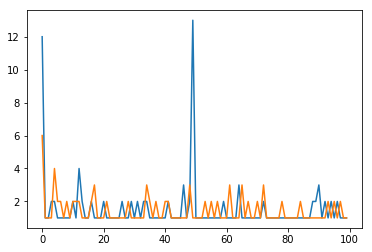

In [115]:
import matplotlib.pyplot as plt
plt.plot(Y_orig)
plt.plot(Y_pred)
plt.savefig('graph.png')
plt.show()


In [116]:
boot = []
for j in range(150):
    alpha = 1
    P = 1; Q = 1
    t1 = []; t2 = []
    nu = list(np.random.uniform(0,2, max(P, Q)))
    Y = []
    for i in range(max(P, Q)):
        x = np.random.poisson(np.exp(nu[i]))
        while x==0:
            x = np.random.poisson(np.exp(nu[i]))
        Y.append(x)
        t1.append(np.log(Y[i]) - np.dot(X[i], Beta))
        t2.append(np.log(Y[i]) - nu[i])

    for i in range(max(P, Q), N):
        nu_ = np.dot(X[i], Beta) + np.dot(Phi, t1[:(-P-1):-1]) + np.dot(Theta, t2[:(-Q-1):-1])
        #print(np.exp(nu_))
        nu.append(nu_)
        try:
            if i!=(t_o - 1):
                x = np.random.poisson(np.exp(nu_))
                while x==0:
                    x = np.random.poisson(np.exp(nu_))
                Y.append(x)
            else:
                x = np.random.poisson(alpha*np.exp(nu_))
                while x==0:
                    x = np.random.poisson(alpha*np.exp(nu[i]))
                Y.append(x)

            if i<(N-1):
                t1.append(np.log(x) - np.dot(X[i+1], Beta))
                t2.append(np.log(x) - nu_)
        except:
            break
    Y = np.array(Y)
    #mu = np.exp(np.array(nu))
    try:
        beta0, phi0, theta0, alpha0 = loggarma_null(X=X,Y=Y,p=2,q=4,max_iter=50,t_0=50)
        mu_o = np.exp(np.array(nu[:4]))
        mu_o = cal_mu(beta0, phi0,theta0, X, Y, mu_o)
        beta, phi, theta, alpha = loggarma(X,Y,2,4,50,i)
        mu_a = np.exp(np.array(nu[:4]))
        mu_a = cal_mu(beta, phi, theta, X, Y, mu_a)
        boot.append(Test_stat(Y[A], mu_o[A], mu_a[A]))
    except:
        continue

(100, 2) Xs
(2,) bea
iteration:  9
[[ 2.45130779e+02  1.10117823e+04  1.01004861e+06  1.19742247e+06
   1.14813250e+06  1.53250751e+06  9.64228421e+05 -1.05699367e+04]]
(2, 1) yyy
(8, 1)
{'beta': array([[  245.13077866],
       [11011.78232485]]), 'phi': array([[1010048.60631147],
       [1197422.47335639]]), 'theta': array([[1148132.49729566],
       [1532507.5058199 ],
       [ 964228.42098689],
       [ -10569.9366847 ]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[  0.51115338  -0.30824478  30.43133759  29.69496536 -19.77131038
  -15.79995849 -15.20716282 -64.51515966]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 0.51115338],
       [-0.30824478]]), 'phi': array([[30.43133759],
       [29.69496536]]), 'theta': array([[-19.77131038],
       [-15.79995849],
       [-15.20716282],
       [-64.51515966]]), 'alpha': 1.0}


/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:76: RuntimeWarning: overflow encountered in exp
/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in add


iteration:  19
[[-2.22076256e-07  3.30967785e-07 -1.99503080e+08 -2.76467262e+08
   1.94080420e+08  1.46813235e+08  1.37231664e+08 -2.15497772e+06]]
(2, 1) yyy
(8, 1)
{'beta': array([[-2.22076256e-07],
       [ 3.30967785e-07]]), 'phi': array([[-1.99503080e+08],
       [-2.76467262e+08]]), 'theta': array([[ 1.94080420e+08],
       [ 1.46813235e+08],
       [ 1.37231664e+08],
       [-2.15497772e+06]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 1.43331806e+09 -3.46303685e+09 -4.70546777e+10 -2.69217767e+10
  -6.49745975e+09  1.56198096e+08 -1.21206073e+09  7.20390950e+09]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 1.43331806e+09],
       [-3.46303685e+09]]), 'phi': array([[-4.70546777e+10],
       [-2.69217767e+10]]), 'theta': array([[-6.49745975e+09],
       [ 1.56198096e+08],
       [-1.21206073e+09],
       [ 7.20390950e+09]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 6.36939839e-17  7.13002600e-17 -2.14109468e-16  1.37472453e-15
   1.18840357e-15  5.97244028e-16  2.59

/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in subtract


iteration:  19
[[-0.03586481 -0.1152033  -0.20812783 -0.04704126 -0.11506569  0.18984214
   0.04459105  0.34937194]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.03586481],
       [-0.1152033 ]]), 'phi': array([[-0.20812783],
       [-0.04704126]]), 'theta': array([[-0.11506569],
       [ 0.18984214],
       [ 0.04459105],
       [ 0.34937194]]), 'alpha': 1.0}
iteration:  29
[[-0.03729084 -0.15002087  0.04665743 -0.660892   -0.19213149  0.41304324
   0.68282616  0.25554798]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.03729084],
       [-0.15002087]]), 'phi': array([[ 0.04665743],
       [-0.660892  ]]), 'theta': array([[-0.19213149],
       [ 0.41304324],
       [ 0.68282616],
       [ 0.25554798]]), 'alpha': 1.0}
iteration:  39
[[-0.23791505  0.14987618  2.32497864 -0.31675116 -3.10205886  4.6833988
  -5.61410776  0.28842037]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.23791505],
       [ 0.14987618]]), 'phi': array([[ 2.32497864],
       [-0.31675116]]), 'theta': array([[-3.10205886],
       [ 4.6833

/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in subtract


iteration:  19
[[-2.75624845e-01  1.20857000e+00  1.50395956e-04 -1.71921533e-06
   7.80888608e-03 -6.86151203e-02  4.92466491e-01 -1.42437600e+00]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.27562485],
       [ 1.20857   ]]), 'phi': array([[ 1.50395956e-04],
       [-1.71921533e-06]]), 'theta': array([[ 0.00780889],
       [-0.06861512],
       [ 0.49246649],
       [-1.424376  ]]), 'alpha': 1.0}
iteration:  29
[[-1.92445813e-25 -2.84598591e-25 -4.82580929e-14 -4.15794945e-14
   1.49241610e-14 -3.01560107e-14 -3.40429572e-14  5.00010001e-14]]
(2, 1) yyy
(8, 1)
{'beta': array([[-1.92445813e-25],
       [-2.84598591e-25]]), 'phi': array([[-4.82580929e-14],
       [-4.15794945e-14]]), 'theta': array([[ 1.49241610e-14],
       [-3.01560107e-14],
       [-3.40429572e-14],
       [ 5.00010001e-14]]), 'alpha': 1.0}
iteration:  39
[[-0.06031997 -0.18997721  0.02111624  0.22980232  0.06731362 -0.11035363
  -0.31234599 -0.15932852]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.06031997],
       [-0.1899772

/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in exp


(100, 2) Xs
(2,) bea
iteration:  9
[[  0.18801702  -0.35645458  -2.7728604  -14.65795029  16.42310226
   -1.8606908   14.41816068   8.35531924]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 0.18801702],
       [-0.35645458]]), 'phi': array([[ -2.7728604 ],
       [-14.65795029]]), 'theta': array([[16.42310226],
       [-1.8606908 ],
       [14.41816068],
       [ 8.35531924]]), 'alpha': 1.0}
iteration:  19
[[ 4.44444444e-01  4.44444444e-01 -1.22997702e+04  2.97347634e+04
  -1.54511408e+04  7.05678458e+04 -6.06693558e+04 -1.18816960e+04]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.44444444],
       [0.44444444]]), 'phi': array([[-12299.77017807],
       [ 29734.76341702]]), 'theta': array([[-15451.14081405],
       [ 70567.84577138],
       [-60669.35576834],
       [-11881.69596201]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[-1.15988070e-19 -4.95554138e-20  5.18624541e-17 -5.16047308e-18
   1.68346215e-17 -1.38872678e-17 -2.59148630e-17 -2.71084831e-17]]
(2, 1) yyy
(8, 1)
{'beta': array([[

/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


iteration:  9
[[-3.23277267e+05 -3.20119340e+01 -1.69849565e+08 -1.75354502e+08
   1.02174482e+08  9.56549051e+07 -4.34356443e+07 -7.65447908e+07
   8.48460828e+10]]
(9, 1)
{'beta': array([[-3.23277267e+05],
       [-3.20119340e+01]]), 'phi': array([[-1.69849565e+08],
       [-1.75354502e+08]]), 'theta': array([[ 1.02174482e+08],
       [ 9.56549051e+07],
       [-4.34356443e+07],
       [-7.65447908e+07]]), 'alpha': 84846082780.30067}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 3.20111217e-01 -4.89315077e-02  3.15789549e+01 -8.56267149e+01
   1.11418044e+01  3.97155300e+00  1.80900734e+01 -4.34025223e+01]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 0.32011122],
       [-0.04893151]]), 'phi': array([[ 31.57895486],
       [-85.6267149 ]]), 'theta': array([[ 11.14180442],
       [  3.971553  ],
       [ 18.09007341],
       [-43.40252232]]), 'alpha': 1.0}
iteration:  19
[[ 1.25473375e-05 -8.10505502e-06 -3.08445859e+01  3.08445736e+01
   1.22651738e+01 -1.85126542e+01  8.79824995e+00 -3.54838180e+00

iteration:  29
[[-0.01084068 -0.17541274 -0.07148075 -0.1664043  -0.15760653  0.07677367
  -0.1011631  -0.18877901]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.01084068],
       [-0.17541274]]), 'phi': array([[-0.07148075],
       [-0.1664043 ]]), 'theta': array([[-0.15760653],
       [ 0.07677367],
       [-0.1011631 ],
       [-0.18877901]]), 'alpha': 1.0}
iteration:  39
[[-0.00422274 -0.25308161 -0.26887905 -0.53826134 -0.19467102  0.02015987
   0.04526681 -0.15349323]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.00422274],
       [-0.25308161]]), 'phi': array([[-0.26887905],
       [-0.53826134]]), 'theta': array([[-0.19467102],
       [ 0.02015987],
       [ 0.04526681],
       [-0.15349323]]), 'alpha': 1.0}
iteration:  49
[[ 0.02119487 -0.31081433 -0.58862198 -0.79848127 -0.19523005  0.00168363
  -0.00704152 -0.09628073]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 0.02119487],
       [-0.31081433]]), 'phi': array([[-0.58862198],
       [-0.79848127]]), 'theta': array([[-0.19523005],
       [ 0.001

iteration:  39
[[-1.04385261e-01 -4.58496539e-01  3.43411772e-01  1.70155643e-02
  -4.75439790e-01  4.44470528e-01 -3.52292731e-02 -4.09427125e-01
   1.46174745e-09]]
(9, 1)
{'beta': array([[-0.10438526],
       [-0.45849654]]), 'phi': array([[0.34341177],
       [0.01701556]]), 'theta': array([[-0.47543979],
       [ 0.44447053],
       [-0.03522927],
       [-0.40942712]]), 'alpha': 1.461747445308248e-09}
iteration:  49
[[-1.41108163e-01 -5.20908889e-01  4.25064389e-01  1.80692662e-02
  -5.22015493e-01  5.40176244e-01 -2.94143044e-02 -4.83084254e-01
   1.52712987e-09]]
(9, 1)
{'beta': array([[-0.14110816],
       [-0.52090889]]), 'phi': array([[0.42506439],
       [0.01806927]]), 'theta': array([[-0.52201549],
       [ 0.54017624],
       [-0.0294143 ],
       [-0.48308425]]), 'alpha': 1.5271298670072042e-09}
(100, 2) Xs
(2,) bea
iteration:  9
[[-1.39601849e+07  4.62894176e+07  1.29604739e+10 -3.19789362e+10
   1.96612920e+10  2.37244421e+10  5.62679806e+09 -8.33419860e+09]]
(2, 1) y

iteration:  29
[[-0.05114814 -0.09343886  0.05337554  0.10709175 -0.01423912  0.0197381
  -0.08701051 -0.20816916]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.05114814],
       [-0.09343886]]), 'phi': array([[0.05337554],
       [0.10709175]]), 'theta': array([[-0.01423912],
       [ 0.0197381 ],
       [-0.08701051],
       [-0.20816916]]), 'alpha': 1.0}
iteration:  39
[[-0.0950571  -0.13947603  0.13280036  0.35879712  0.00518928  0.00979603
  -0.3473252  -0.49837606]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.0950571 ],
       [-0.13947603]]), 'phi': array([[0.13280036],
       [0.35879712]]), 'theta': array([[ 0.00518928],
       [ 0.00979603],
       [-0.3473252 ],
       [-0.49837606]]), 'alpha': 1.0}
iteration:  49
[[-0.13820865 -0.11995603 -0.13021813  0.48029867  0.0076526   0.06017328
  -0.43631269 -0.43177012]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.13820865],
       [-0.11995603]]), 'phi': array([[-0.13021813],
       [ 0.48029867]]), 'theta': array([[ 0.0076526 ],
       [ 0.06017328

iteration:  19
[[-0.03861648 -0.07103008 -0.19609264 -0.28053387 -0.07321592  0.02187442
   0.38730179  0.12215133]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.03861648],
       [-0.07103008]]), 'phi': array([[-0.19609264],
       [-0.28053387]]), 'theta': array([[-0.07321592],
       [ 0.02187442],
       [ 0.38730179],
       [ 0.12215133]]), 'alpha': 1.0}
iteration:  29
[[-0.06166799 -0.12669256 -0.12726739 -0.13626305 -0.15588819  0.05294769
   0.31927396 -0.07117768]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.06166799],
       [-0.12669256]]), 'phi': array([[-0.12726739],
       [-0.13626305]]), 'theta': array([[-0.15588819],
       [ 0.05294769],
       [ 0.31927396],
       [-0.07117768]]), 'alpha': 1.0}
iteration:  39
[[-0.08342048 -0.15767317 -0.141469   -0.03747372 -0.19019203  0.10728794
   0.25385087 -0.10330961]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.08342048],
       [-0.15767317]]), 'phi': array([[-0.141469  ],
       [-0.03747372]]), 'theta': array([[-0.19019203],
       [ 0.107

       [-0.27348375]]), 'alpha': 1.0}
iteration:  49
[[-0.14066196 -0.42491646  0.53455017 -0.31637178 -0.02779459 -0.03090611
   0.00875581 -0.13289966]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.14066196],
       [-0.42491646]]), 'phi': array([[ 0.53455017],
       [-0.31637178]]), 'theta': array([[-0.02779459],
       [-0.03090611],
       [ 0.00875581],
       [-0.13289966]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[ 3.93296638e-18 -9.14652991e-18  8.43381296e-16  5.43312802e-16
  -2.21875459e-16  3.22371996e-16 -2.79006031e-16  6.88603814e-17
   5.28557180e-47]]
(9, 1)
{'beta': array([[ 3.93296638e-18],
       [-9.14652991e-18]]), 'phi': array([[8.43381296e-16],
       [5.43312802e-16]]), 'theta': array([[-2.21875459e-16],
       [ 3.22371996e-16],
       [-2.79006031e-16],
       [ 6.88603814e-17]]), 'alpha': 5.28557180156693e-47}
iteration:  19
[[-5.50765254e-02 -1.39997619e-01 -9.57572718e-02  1.38796726e-02
   8.05541568e-02  8.88271166e-03 -1.21585565e-01  4.89480479e-02
   9.9151

iteration:  49
[[-0.04784239 -0.04016541 -0.51311674 -0.29642075 -0.0775714   0.11987265
   0.22385652  0.20995284]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.04784239],
       [-0.04016541]]), 'phi': array([[-0.51311674],
       [-0.29642075]]), 'theta': array([[-0.0775714 ],
       [ 0.11987265],
       [ 0.22385652],
       [ 0.20995284]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[ 5.09702473e-19  5.28426271e-20  1.21323707e-16  8.56965642e-17
  -7.29712325e-17 -1.93271227e-17  1.43118091e-17 -7.01986414e-17
   3.50394285e-47]]
(9, 1)
{'beta': array([[5.09702473e-19],
       [5.28426271e-20]]), 'phi': array([[1.21323707e-16],
       [8.56965642e-17]]), 'theta': array([[-7.29712325e-17],
       [-1.93271227e-17],
       [ 1.43118091e-17],
       [-7.01986414e-17]]), 'alpha': 3.5039428473632283e-47}
iteration:  19
[[-2.96337119e-02 -4.95309417e-02 -2.05080567e-02  4.82074602e-01
   3.26143745e-03  7.20224957e-02 -4.78385843e-01 -8.62280481e-02
   9.43037315e-12]]
(9, 1)
{'beta': array([[-0.

iteration:  39
[[ 4.88168097e-25 -4.82153410e-25 -3.17178502e-13 -9.22523346e-14
  -2.20798747e-14 -2.58677173e-15 -1.17978372e-13  1.10511391e-13]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 4.88168097e-25],
       [-4.82153410e-25]]), 'phi': array([[-3.17178502e-13],
       [-9.22523346e-14]]), 'theta': array([[-2.20798747e-14],
       [-2.58677173e-15],
       [-1.17978372e-13],
       [ 1.10511391e-13]]), 'alpha': 1.0}
iteration:  49
[[-0.0477738  -0.06497557  0.34197535  0.19419683  0.07759922  0.07994881
  -0.02125162 -0.42469052]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.0477738 ],
       [-0.06497557]]), 'phi': array([[0.34197535],
       [0.19419683]]), 'theta': array([[ 0.07759922],
       [ 0.07994881],
       [-0.02125162],
       [-0.42469052]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[-9.04880002e+02  7.18176841e+02 -1.42870519e+05 -1.82578849e+05
  -2.40428281e+04  2.95732586e+04  8.95907084e+04  2.03685920e+04
  -1.53538965e+06]]
(9, 1)
{'beta': array([[-904.88000188],
       [ 71

iteration:  19
[[ 1.55689964e-01  2.98387097e-01 -1.46065782e+05  3.98772598e+05
  -1.27345266e+00  1.62673817e+05 -3.48100690e+05 -6.72793811e+04]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.15568996],
       [0.2983871 ]]), 'phi': array([[-146065.78201992],
       [ 398772.59793014]]), 'theta': array([[-1.27345266e+00],
       [ 1.62673817e+05],
       [-3.48100690e+05],
       [-6.72793811e+04]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 0.05890683  0.17937536 -2.28008629 -1.77075789  1.40394839 -2.90003908
   2.20927705  3.39421058]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.05890683],
       [0.17937536]]), 'phi': array([[-2.28008629],
       [-1.77075789]]), 'theta': array([[ 1.40394839],
       [-2.90003908],
       [ 2.20927705],
       [ 3.39421058]]), 'alpha': 1.0}
iteration:  19
[[ 3.97174123e-28  6.27512748e-27  3.74344514e-28  1.99177317e-22
   2.25474832e-24 -1.59543069e-22 -3.50457471e-23 -6.84288909e-24]]
(2, 1) yyy
(8, 1)
{'beta': array([[3.97174123e-28],
       [6.275

iteration:  19
[[-1.12139918e-01  3.87860082e-01  1.11021954e+00 -1.75597490e+00
  -7.04434759e-02  3.47837829e-02  5.13816060e-02  8.21620972e-03
   1.42739161e-40]]
(9, 1)
{'beta': array([[-0.11213992],
       [ 0.38786008]]), 'phi': array([[ 1.11021954],
       [-1.7559749 ]]), 'theta': array([[-0.07044348],
       [ 0.03478378],
       [ 0.05138161],
       [ 0.00821621]]), 'alpha': 1.4273916066272204e-40}
iteration:  29
[[-1.26619158e-01  4.10048880e-01  1.34581925e+02 -1.40117649e+02
   2.51482608e+01 -1.37868748e+02 -1.08347957e+02 -2.06066951e+02
   1.19594756e-09]]
(9, 1)
{'beta': array([[-0.12661916],
       [ 0.41004888]]), 'phi': array([[ 134.58192473],
       [-140.11764915]]), 'theta': array([[  25.14826084],
       [-137.86874837],
       [-108.34795691],
       [-206.06695129]]), 'alpha': 1.1959475632039585e-09}
iteration:  39
[[-2.99820857e-03  3.77809514e-03 -7.66705507e-03  8.97089288e-03
   2.21428699e-03 -2.67398180e-04  3.81468939e-02 -1.02667540e+00
   1.77052631

iteration:  9
[[  0.32870422  -0.22793652  -3.11775031   7.12513631  -6.00016018
  -13.66981254  10.35389588  -7.8136535 ]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 0.32870422],
       [-0.22793652]]), 'phi': array([[-3.11775031],
       [ 7.12513631]]), 'theta': array([[ -6.00016018],
       [-13.66981254],
       [ 10.35389588],
       [ -7.8136535 ]]), 'alpha': 1.0}
iteration:  19
[[-3.45383705e-24  2.94605597e-24  9.16732805e-11  2.07956938e-10
   3.44801308e-10 -5.23031979e-10 -1.56002201e-10  3.46026539e-11]]
(2, 1) yyy
(8, 1)
{'beta': array([[-3.45383705e-24],
       [ 2.94605597e-24]]), 'phi': array([[9.16732805e-11],
       [2.07956938e-10]]), 'theta': array([[ 3.44801308e-10],
       [-5.23031979e-10],
       [-1.56002201e-10],
       [ 3.46026539e-11]]), 'alpha': 1.0}
iteration:  29
[[-0.05139239 -0.11567799  0.08999478  0.08735297 -0.03069595  0.10740813
  -0.05441986 -0.27451099]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.05139239],
       [-0.11567799]]), 'phi': array([[0.08999478

/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in add


iteration:  9
[[ 3.07314657e+07  2.48050243e+07  1.21337223e+11 -2.16372354e+11
  -1.14224454e+11 -1.64830902e+10 -3.03805340e+10 -9.87968245e+10]]
(2, 1) yyy
(8, 1)
{'beta': array([[30731465.71911078],
       [24805024.29759501]]), 'phi': array([[ 1.21337223e+11],
       [-2.16372354e+11]]), 'theta': array([[-1.14224454e+11],
       [-1.64830902e+10],
       [-3.03805340e+10],
       [-9.87968245e+10]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[-0.69585468 -0.06103505 -0.03128944  1.34930149  1.39469893 -1.10215843
   1.2696399   2.28044394]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.69585468],
       [-0.06103505]]), 'phi': array([[-0.03128944],
       [ 1.34930149]]), 'theta': array([[ 1.39469893],
       [-1.10215843],
       [ 1.2696399 ],
       [ 2.28044394]]), 'alpha': 1.0}
iteration:  19
[[-2.36819373e-19  2.74354529e-18 -2.15592232e-13  4.52340007e-13
  -2.93297938e-13  5.29829788e-13  6.86972278e-13  2.55571890e-13]]
(2, 1) yyy
(8, 1)
{'beta': array([[-2.36819373e-19],

iteration:  29
[[-0.02752478 -0.06659331  0.13135959 -0.03914089  0.01844728 -0.12535076
  -0.01916053 -0.05773616]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.02752478],
       [-0.06659331]]), 'phi': array([[ 0.13135959],
       [-0.03914089]]), 'theta': array([[ 0.01844728],
       [-0.12535076],
       [-0.01916053],
       [-0.05773616]]), 'alpha': 1.0}
iteration:  39
[[-0.04559562 -0.10013253  0.52336928 -0.15736712  0.05061834 -0.20939838
   0.0566079  -0.33821345]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.04559562],
       [-0.10013253]]), 'phi': array([[ 0.52336928],
       [-0.15736712]]), 'theta': array([[ 0.05061834],
       [-0.20939838],
       [ 0.0566079 ],
       [-0.33821345]]), 'alpha': 1.0}
iteration:  49
[[-0.04605881 -0.06743637  1.07910403 -0.28723278  0.03581696 -0.25793126
   0.08354988 -0.67118843]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.04605881],
       [-0.06743637]]), 'phi': array([[ 1.07910403],
       [-0.28723278]]), 'theta': array([[ 0.03581696],
       [-0.257

iteration:  9
[[ 0.38936018 -0.14666412 -6.11767873 -1.41616977 -2.86403037  2.16492616
   1.46446059  4.96784881]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 0.38936018],
       [-0.14666412]]), 'phi': array([[-6.11767873],
       [-1.41616977]]), 'theta': array([[-2.86403037],
       [ 2.16492616],
       [ 1.46446059],
       [ 4.96784881]]), 'alpha': 1.0}
iteration:  19
[[ 0.35842761  4.39777706 -0.20483181  0.14661085 -0.02288053 -0.07560317
  -0.10126462 -0.04609351]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.35842761],
       [4.39777706]]), 'phi': array([[-0.20483181],
       [ 0.14661085]]), 'theta': array([[-0.02288053],
       [-0.07560317],
       [-0.10126462],
       [-0.04609351]]), 'alpha': 1.0}
iteration:  29
[[ 3.01220491e+07 -4.00796040e+07  3.01429779e+10  1.90309416e+09
   1.70795450e+09  5.20200118e+09  2.24045266e+09 -1.65641419e+10]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 30122049.12190665],
       [-40079604.01786104]]), 'phi': array([[3.01429779e+10],
       [1.90309416e+09]

iteration:  39
[[-0.0288482   0.01188853  0.33082389 -0.12807862 -0.16678166  0.0159767
  -0.19429631 -0.17131505]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.0288482 ],
       [ 0.01188853]]), 'phi': array([[ 0.33082389],
       [-0.12807862]]), 'theta': array([[-0.16678166],
       [ 0.0159767 ],
       [-0.19429631],
       [-0.17131505]]), 'alpha': 1.0}
iteration:  49
[[-0.02846097  0.01473869  0.2500513  -0.08855438 -0.16754067  0.03318992
  -0.37547866 -0.00510417]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.02846097],
       [ 0.01473869]]), 'phi': array([[ 0.2500513 ],
       [-0.08855438]]), 'theta': array([[-0.16754067],
       [ 0.03318992],
       [-0.37547866],
       [-0.00510417]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[ 4.19181931e-17 -1.86841150e-16  1.94731373e-16  1.62864887e-17
   2.07463059e-16 -6.33656295e-17 -2.86641755e-16 -4.22094221e-17
   3.90412930e-49]]
(9, 1)
{'beta': array([[ 4.19181931e-17],
       [-1.86841150e-16]]), 'phi': array([[1.94731373e-16],
       [1.62

iteration:  29
[[-0.11335828 -0.45592418  0.30976875 -0.35275042 -0.02969886  0.22067882
   0.17330386 -0.53149469]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.11335828],
       [-0.45592418]]), 'phi': array([[ 0.30976875],
       [-0.35275042]]), 'theta': array([[-0.02969886],
       [ 0.22067882],
       [ 0.17330386],
       [-0.53149469]]), 'alpha': 1.0}
iteration:  39
[[-0.24782432 -0.9873356  -0.68877447 -1.13126673  0.45004685 -0.01373518
   0.55900355 -0.29442881]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.24782432],
       [-0.9873356 ]]), 'phi': array([[-0.68877447],
       [-1.13126673]]), 'theta': array([[ 0.45004685],
       [-0.01373518],
       [ 0.55900355],
       [-0.29442881]]), 'alpha': 1.0}
iteration:  49
[[ -138.9364426   -433.41333021 -2508.5701294  -4080.07031783
   -874.14231773  -579.78354878   904.33282858  2659.51742251]]
(2, 1) yyy
(8, 1)
{'beta': array([[-138.9364426 ],
       [-433.41333021]]), 'phi': array([[-2508.5701294 ],
       [-4080.07031783]]), 'theta': ar

iteration:  49
[[-0.13370969 -0.3952357  -0.73789221 -0.90099462  0.05692336  0.03790772
   0.69310984 -0.27124285]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.13370969],
       [-0.3952357 ]]), 'phi': array([[-0.73789221],
       [-0.90099462]]), 'theta': array([[ 0.05692336],
       [ 0.03790772],
       [ 0.69310984],
       [-0.27124285]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[ 1.42903961e-18  4.97240109e-18 -5.21969692e-17 -8.18543847e-17
  -1.35304421e-18 -1.64747507e-17  1.97421260e-17 -1.50814111e-17
   1.95565027e-16]]
(9, 1)
{'beta': array([[1.42903961e-18],
       [4.97240109e-18]]), 'phi': array([[-5.21969692e-17],
       [-8.18543847e-17]]), 'theta': array([[-1.35304421e-18],
       [-1.64747507e-17],
       [ 1.97421260e-17],
       [-1.50814111e-17]]), 'alpha': 1.9556502744643373e-16}
iteration:  19
[[-6.16481605e-02 -1.30813604e-01  2.02168681e-01  1.94161130e-01
   9.46343086e-04  8.77517260e-02 -2.30685521e-01 -3.87536675e-01
   1.00703057e-11]]
(9, 1)
{'beta': array([[-

iteration:  29
[[-2.16326834e-31  7.33428966e-32 -5.38400446e-30 -5.39522068e-30
   2.17193828e-29 -6.78146179e-29  7.38707794e-29 -2.16049936e-29]]
(2, 1) yyy
(8, 1)
{'beta': array([[-2.16326834e-31],
       [ 7.33428966e-32]]), 'phi': array([[-5.38400446e-30],
       [-5.39522068e-30]]), 'theta': array([[ 2.17193828e-29],
       [-6.78146179e-29],
       [ 7.38707794e-29],
       [-2.16049936e-29]]), 'alpha': 1.0}
iteration:  39
[[-0.04408536 -0.14607338  0.10018731 -0.02927553 -0.06150087 -0.14309236
   0.09674735 -0.23962156]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.04408536],
       [-0.14607338]]), 'phi': array([[ 0.10018731],
       [-0.02927553]]), 'theta': array([[-0.06150087],
       [-0.14309236],
       [ 0.09674735],
       [-0.23962156]]), 'alpha': 1.0}
iteration:  49
[[-0.06479946 -0.22181364  0.17603931 -0.13625409 -0.05712881 -0.22094441
   0.19655788 -0.40336347]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.06479946],
       [-0.22181364]]), 'phi': array([[ 0.17603931],
     

iteration:  39
[[-0.05136796 -0.36781234 -0.08521557 -0.20035973 -0.16395645 -0.37686225
   0.30530326  0.25995266]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.05136796],
       [-0.36781234]]), 'phi': array([[-0.08521557],
       [-0.20035973]]), 'theta': array([[-0.16395645],
       [-0.37686225],
       [ 0.30530326],
       [ 0.25995266]]), 'alpha': 1.0}
iteration:  49
[[-0.0740237  -0.46758388  0.06918186 -0.11536083 -0.08108029 -0.51923448
   0.22954638  0.15413317]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.0740237 ],
       [-0.46758388]]), 'phi': array([[ 0.06918186],
       [-0.11536083]]), 'theta': array([[-0.08108029],
       [-0.51923448],
       [ 0.22954638],
       [ 0.15413317]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[-1.31175419e+08  2.81836246e+08 -4.14283243e+10 -2.37605060e+10
   3.19123871e+09  6.81786252e+09  4.36505297e+09  1.92349304e+09
  -1.63352081e+10]]
(9, 1)
{'beta': array([[-1.31175419e+08],
       [ 2.81836246e+08]]), 'phi': array([[-4.14283243e+10],
       [-2

iteration:  19
[[-1.86243927e-29  1.43035729e-29  2.35524743e-29 -2.04949416e-29
   5.62645440e-29 -1.01142196e-28 -1.07077571e-29  1.08377836e-28]]
(2, 1) yyy
(8, 1)
{'beta': array([[-1.86243927e-29],
       [ 1.43035729e-29]]), 'phi': array([[ 2.35524743e-29],
       [-2.04949416e-29]]), 'theta': array([[ 5.62645440e-29],
       [-1.01142196e-28],
       [-1.07077571e-29],
       [ 1.08377836e-28]]), 'alpha': 1.0}
iteration:  29
[[-0.02638873 -0.09432504 -0.05489291 -0.01880276 -0.09106995 -0.0316966
  -0.07390123 -0.06582186]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.02638873],
       [-0.09432504]]), 'phi': array([[-0.05489291],
       [-0.01880276]]), 'theta': array([[-0.09106995],
       [-0.0316966 ],
       [-0.07390123],
       [-0.06582186]]), 'alpha': 1.0}
iteration:  39
[[-0.0411132  -0.17626952 -0.36757211 -0.06540908 -0.20988486 -0.09054827
  -0.14707483  0.08035918]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.0411132 ],
       [-0.17626952]]), 'phi': array([[-0.36757211],
      

iteration:  19
[[-9.31267948e-02 -1.89672315e-01 -2.68680635e-01 -4.26318586e-02
  -9.32023260e-02 -9.96880122e-02 -1.53643872e-01  4.70549412e-02
   1.19683152e-11]]
(9, 1)
{'beta': array([[-0.09312679],
       [-0.18967232]]), 'phi': array([[-0.26868063],
       [-0.04263186]]), 'theta': array([[-0.09320233],
       [-0.09968801],
       [-0.15364387],
       [ 0.04705494]]), 'alpha': 1.196831522776165e-11}
iteration:  29
[[-1.80701103e-01 -3.03147087e-01 -5.05148064e-01 -2.14811375e-01
  -7.28554002e-02 -1.26552462e-01 -8.58416209e-02 -6.18044582e-02
   1.29796729e-11]]
(9, 1)
{'beta': array([[-0.1807011 ],
       [-0.30314709]]), 'phi': array([[-0.50514806],
       [-0.21481137]]), 'theta': array([[-0.0728554 ],
       [-0.12655246],
       [-0.08584162],
       [-0.06180446]]), 'alpha': 1.2979672892043936e-11}
iteration:  39
[[-3.21249765e-01 -3.78921696e-01 -7.75842115e-01 -2.48834125e-01
  -1.94571413e-01 -2.23394517e-01  2.52684837e-02  5.57842105e-04
   1.09927067e-11]]
(9, 1)

iteration:  39
[[-0.11450502 -0.32618622 -0.78976047 -0.4283116   0.1193963   0.0067135
   0.19235669  0.12467405]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.11450502],
       [-0.32618622]]), 'phi': array([[-0.78976047],
       [-0.4283116 ]]), 'theta': array([[0.1193963 ],
       [0.0067135 ],
       [0.19235669],
       [0.12467405]]), 'alpha': 1.0}
iteration:  49
[[-0.09201556 -0.39690556 -1.09235794 -0.63211243  0.34343241  0.06369911
   0.34989897  0.15053229]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.09201556],
       [-0.39690556]]), 'phi': array([[-1.09235794],
       [-0.63211243]]), 'theta': array([[0.34343241],
       [0.06369911],
       [0.34989897],
       [0.15053229]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[-2.13776992e-20 -6.10832385e-20  1.19872980e-16 -5.71852089e-17
  -1.42812590e-16 -9.80219383e-17  8.61683175e-18 -1.61258131e-16
   3.30706243e-48]]
(9, 1)
{'beta': array([[-2.13776992e-20],
       [-6.10832385e-20]]), 'phi': array([[ 1.19872980e-16],
       [-5.71852089

iteration:  19
[[ 1.78157076e-24 -3.06134909e-24  3.51479542e-32  6.22099651e-31
   4.71881092e-29  5.11440923e-31 -4.57808481e-29 -6.61443349e-31]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 1.78157076e-24],
       [-3.06134909e-24]]), 'phi': array([[3.51479542e-32],
       [6.22099651e-31]]), 'theta': array([[ 4.71881092e-29],
       [ 5.11440923e-31],
       [-4.57808481e-29],
       [-6.61443349e-31]]), 'alpha': 1.0}
iteration:  29
[[-0.0307161  -0.11304713 -0.30700894  0.0808061  -0.20204796 -0.22344924
  -0.2189854   0.09797667]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.0307161 ],
       [-0.11304713]]), 'phi': array([[-0.30700894],
       [ 0.0808061 ]]), 'theta': array([[-0.20204796],
       [-0.22344924],
       [-0.2189854 ],
       [ 0.09797667]]), 'alpha': 1.0}
iteration:  39
[[-0.03844265 -0.11745176 -0.48876783  0.02512045 -0.1940444  -0.24051642
  -0.15051841  0.10589264]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.03844265],
       [-0.11745176]]), 'phi': array([[-0.48876783],
       

iteration:  9
[[  0.33267468  -0.02029802 -18.0541421   -5.22736145  -0.3113282
    4.13982965   3.60005755  18.44612021]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 0.33267468],
       [-0.02029802]]), 'phi': array([[-18.0541421 ],
       [ -5.22736145]]), 'theta': array([[-0.3113282 ],
       [ 4.13982965],
       [ 3.60005755],
       [18.44612021]]), 'alpha': 1.0}
iteration:  19
[[ 0.21971829  0.83223552 -0.18819815  0.08645663 -2.54203484 -2.38133677
  -0.52773859 -0.02217298]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.21971829],
       [0.83223552]]), 'phi': array([[-0.18819815],
       [ 0.08645663]]), 'theta': array([[-2.54203484],
       [-2.38133677],
       [-0.52773859],
       [-0.02217298]]), 'alpha': 1.0}
iteration:  29
[[-7.83951543e-23  8.19923501e-23  1.22421611e-08 -4.96641877e-09
   2.01670638e-08 -2.62927760e-09  7.15019763e-09 -7.47940397e-09]]
(2, 1) yyy
(8, 1)
{'beta': array([[-7.83951543e-23],
       [ 8.19923501e-23]]), 'phi': array([[ 1.22421611e-08],
       [-4.96641877

iteration:  29
[[ 5.22394091e-01  3.02505416e-01 -5.43084048e+09 -8.47920670e+09
  -6.46396834e+08 -6.64752911e+09  1.45102318e+09  2.11627199e+08]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.52239409],
       [0.30250542]]), 'phi': array([[-5.43084048e+09],
       [-8.47920670e+09]]), 'theta': array([[-6.46396834e+08],
       [-6.64752911e+09],
       [ 1.45102318e+09],
       [ 2.11627199e+08]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[-0.48128302  0.1351914  -2.40662026 -3.51205944 -1.2404092  -0.10120803
   4.62442639  1.31768649]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.48128302],
       [ 0.1351914 ]]), 'phi': array([[-2.40662026],
       [-3.51205944]]), 'theta': array([[-1.2404092 ],
       [-0.10120803],
       [ 4.62442639],
       [ 1.31768649]]), 'alpha': 1.0}
iteration:  19
[[-1.34669852e-27  1.54468942e-27  1.21209280e-30 -8.77976373e-31
  -8.74997247e-31  1.51706868e-29 -3.60601283e-30  2.90638561e-31]]
(2, 1) yyy
(8, 1)
{'beta': array([[-1.34669852e-27],
       [ 1.5

iteration:  29
[[-5.23470669e-02  4.38901944e-02  5.91613025e+10  2.64889100e+10
  -2.08108550e+10  1.73188874e+10 -1.30574682e+10  4.92218283e+10]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.05234707],
       [ 0.04389019]]), 'phi': array([[5.91613025e+10],
       [2.64889100e+10]]), 'theta': array([[-2.08108550e+10],
       [ 1.73188874e+10],
       [-1.30574682e+10],
       [ 4.92218283e+10]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 0.20462524  0.03997857 -1.83563874  0.58886894 -0.77559233 -0.48432973
   0.1738029   2.14931334]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.20462524],
       [0.03997857]]), 'phi': array([[-1.83563874],
       [ 0.58886894]]), 'theta': array([[-0.77559233],
       [-0.48432973],
       [ 0.1738029 ],
       [ 2.14931334]]), 'alpha': 1.0}
iteration:  19
[[-8.01306398e-24 -2.77728641e-24 -1.05606899e-29  8.66293826e-30
   4.42932010e-29 -1.01308093e-26 -1.73260445e-26 -7.31951800e-27]]
(2, 1) yyy
(8, 1)
{'beta': array([[-8.01306398e-24],
       [-2.777

iteration:  39
[[ 1.51615733e-06 -3.29506525e-06 -1.16249503e-01  5.86049612e-04
   6.34673824e-02 -8.41970725e-02 -2.12407073e-01 -2.90912505e-01]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 1.51615733e-06],
       [-3.29506525e-06]]), 'phi': array([[-0.1162495 ],
       [ 0.00058605]]), 'theta': array([[ 0.06346738],
       [-0.08419707],
       [-0.21240707],
       [-0.29091251]]), 'alpha': 1.0}
iteration:  49
[[-0.0148288   0.01096548 -0.37881083 -0.09631151  0.03221011 -0.15087932
  -0.18786239 -0.21777304]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.0148288 ],
       [ 0.01096548]]), 'phi': array([[-0.37881083],
       [-0.09631151]]), 'theta': array([[ 0.03221011],
       [-0.15087932],
       [-0.18786239],
       [-0.21777304]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[ 3.20512967e-01 -5.82115887e-02  1.15953365e+01  5.98996798e+01
  -1.80115049e+01 -4.70399394e+01 -4.22546975e+01 -1.00928685e+02
   2.81430208e+02]]
(9, 1)
{'beta': array([[ 0.32051297],
       [-0.05821159]]), 'phi': arra

/home/harshv834/anaconda3/envs/ml_def/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


iteration:  9
[[ 9.66522577e+05 -4.19433611e+07  1.00378874e+10 -5.54209537e+09
  -5.78226586e+09 -8.29116158e+09  6.27710924e+09 -1.14351119e+10]]
(2, 1) yyy
(8, 1)
{'beta': array([[   966522.57668037],
       [-41943361.08665989]]), 'phi': array([[ 1.00378874e+10],
       [-5.54209537e+09]]), 'theta': array([[-5.78226586e+09],
       [-8.29116158e+09],
       [ 6.27710924e+09],
       [-1.14351119e+10]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 0.29417655  0.03961997  0.65577253 -0.39154018  0.58654225  0.02889407
   1.90314947  0.33883244]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.29417655],
       [0.03961997]]), 'phi': array([[ 0.65577253],
       [-0.39154018]]), 'theta': array([[0.58654225],
       [0.02889407],
       [1.90314947],
       [0.33883244]]), 'alpha': 1.0}
iteration:  19
[[-1.63624259e-23 -3.68325664e-23 -5.58344065e-27  2.15794448e-27
   3.86359729e-29  3.58626980e-27  3.45405725e-27  3.29722646e-27]]
(2, 1) yyy
(8, 1)
{'beta': array([[-1.63624259e-23],
   

iteration:  29
[[ 1.66233766e-01  7.53246753e-02  5.55411693e+01 -5.70854883e+01
  -1.14519395e+00 -1.49895596e+00 -3.44713199e-01 -5.40009997e-03]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.16623377],
       [0.07532468]]), 'phi': array([[ 55.54116931],
       [-57.08548834]]), 'theta': array([[-1.14519395],
       [-1.49895596],
       [-0.3447132 ],
       [-0.0054001 ]]), 'alpha': 1.0}
iteration:  39
[[ 0.76693281  0.26219237 -0.06654163 -0.03641825 -0.00795748  0.13292391
  -2.37889881  2.23420073]]
(2, 1) yyy
(8, 1)
{'beta': array([[0.76693281],
       [0.26219237]]), 'phi': array([[-0.06654163],
       [-0.03641825]]), 'theta': array([[-0.00795748],
       [ 0.13292391],
       [-2.37889881],
       [ 2.23420073]]), 'alpha': 1.0}
iteration:  49
[[ 5.80872420e-32  4.34590490e-32 -4.96327649e-33  5.76522131e-32
  -6.67748364e-30 -8.27550638e-28 -1.43950468e-27 -6.23077202e-28]]
(2, 1) yyy
(8, 1)
{'beta': array([[5.8087242e-32],
       [4.3459049e-32]]), 'phi': array([[-4.96327649e-33],

iteration:  39
[[-0.11215651 -0.24080261 -0.56912946 -0.20344012 -0.40184603  0.07864754
  -0.2097491   0.19889295]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.11215651],
       [-0.24080261]]), 'phi': array([[-0.56912946],
       [-0.20344012]]), 'theta': array([[-0.40184603],
       [ 0.07864754],
       [-0.2097491 ],
       [ 0.19889295]]), 'alpha': 1.0}
iteration:  49
[[-0.12679071 -0.2781313  -0.50571395 -0.70981552 -0.67259918  0.13455962
   0.2718937   0.11203987]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.12679071],
       [-0.2781313 ]]), 'phi': array([[-0.50571395],
       [-0.70981552]]), 'theta': array([[-0.67259918],
       [ 0.13455962],
       [ 0.2718937 ],
       [ 0.11203987]]), 'alpha': 1.0}
(100, 2)
iteration:  9
[[-1.22562084e+02 -4.36155182e+01 -3.07609994e+03  1.53620897e+05
  -1.53850294e+05  8.95734344e+04 -1.74780822e+05 -1.12201270e+04
   2.76627119e+04]]
(9, 1)
{'beta': array([[-122.56208355],
       [ -43.61551817]]), 'phi': array([[ -3076.09994193],
       [153620

iteration:  29
[[-0.18340183 -0.11195667 -0.2145926   0.08946101  0.02682702 -0.40296942
  -0.49342435 -0.53950174]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.18340183],
       [-0.11195667]]), 'phi': array([[-0.2145926 ],
       [ 0.08946101]]), 'theta': array([[ 0.02682702],
       [-0.40296942],
       [-0.49342435],
       [-0.53950174]]), 'alpha': 1.0}
iteration:  39
[[-0.18361053 -0.11199328 -0.34210958  0.20439003  0.06000476 -0.3829735
  -0.63491094 -0.45491495]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.18361053],
       [-0.11199328]]), 'phi': array([[-0.34210958],
       [ 0.20439003]]), 'theta': array([[ 0.06000476],
       [-0.3829735 ],
       [-0.63491094],
       [-0.45491495]]), 'alpha': 1.0}
iteration:  49
[[-0.18362775 -0.11198939 -0.47078338  0.31717657  0.09003282 -0.36701046
  -0.75511387 -0.38339387]]
(2, 1) yyy
(8, 1)
{'beta': array([[-0.18362775],
       [-0.11198939]]), 'phi': array([[-0.47078338],
       [ 0.31717657]]), 'theta': array([[ 0.09003282],
       [-0.3670

iteration:  9
[[-4.10118314e-20  2.70420145e-19 -1.12731406e-17 -1.06408038e-16
   2.39225704e-17  5.84528620e-17  5.35727748e-17  1.82705193e-17
  -2.04121435e-48]]
(9, 1)
{'beta': array([[-4.10118314e-20],
       [ 2.70420145e-19]]), 'phi': array([[-1.12731406e-17],
       [-1.06408038e-16]]), 'theta': array([[2.39225704e-17],
       [5.84528620e-17],
       [5.35727748e-17],
       [1.82705193e-17]]), 'alpha': -2.0412143477761485e-48}
(100, 2) Xs
(2,) bea
iteration:  9
[[-6.82675713e+03  8.87329854e+03 -5.09521052e+07 -1.56684335e+07
  -1.49394229e+07 -1.73352650e+07  3.09048618e+07  1.64554174e+06]]
(2, 1) yyy
(8, 1)
{'beta': array([[-6826.75713262],
       [ 8873.2985394 ]]), 'phi': array([[-50952105.24896206],
       [-15668433.50334628]]), 'theta': array([[-14939422.90538151],
       [-17335264.96629424],
       [ 30904861.83114617],
       [  1645541.73600343]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[-18.12987578  23.29374579 -10.56692909  14.97510478  -8.67011077


iteration:  9
[[ 1.18405082e+00 -1.47945835e+00  9.98054760e+02 -2.15919585e+03
   1.71737524e+03 -5.77472790e+02  1.53991507e+03 -8.01794705e+02]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 1.18405082],
       [-1.47945835]]), 'phi': array([[  998.05475978],
       [-2159.19585307]]), 'theta': array([[1717.3752419 ],
       [-577.47278976],
       [1539.91506959],
       [-801.7947054 ]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 7.30975623e+07 -2.88748020e+07  1.75618468e+11 -3.77547892e+09
  -8.04790438e+10 -6.36616166e+10  2.07994166e+10 -1.10374572e+11]]
(2, 1) yyy
(8, 1)
{'beta': array([[ 73097562.32044773],
       [-28874801.97992927]]), 'phi': array([[ 1.75618468e+11],
       [-3.77547892e+09]]), 'theta': array([[-8.04790438e+10],
       [-6.36616166e+10],
       [ 2.07994166e+10],
       [-1.10374572e+11]]), 'alpha': 1.0}
(100, 2) Xs
(2,) bea
iteration:  9
[[ 0.52158152 -0.23230217 -1.41308126  8.33765185  2.86232118 -1.6887442
   0.88345906  2.82567657]]
(2, 1) yyy
(8, 1)

In [117]:
boot

[-15.96594725015434,
 -14.78685554050865,
 -2.172473610620199,
 -2.6189732692143695,
 -1.6937815728807135,
 96859.79768515953,
 -8.946967311263103,
 nan,
 -2.078266126733161,
 7510285708.123689,
 nan,
 -47.87602689649011,
 -1.8456698629599917,
 -14.868072621059614,
 -16.076180327549206,
 -10.204414101685002,
 -30.49206622168717,
 -1.0572596588995597e+126,
 -1.949928232079093,
 1382676312902.5708,
 nan,
 -7.520624137657413e+142]

In [ ]:
def Test_stat(Y, mu_o, mu_a):
    """
    Y -> Value of Y at t_o
    mu_o -> Value of mu of NULL model
    mu_a -> Value of mu of Alternate model
    """
    c = 0.0000001
    a = np.array([max(mu_o[i] - mu_a[i], c) for i in range(len(Y))])
    return -2*(mu_o - mu_a) + Y*np.log(a)
Test = Test_stat(Y, mu_o, mu_a)
print(Test)